# Image Segmentation V1

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [2]:
#dataset,info = tfds.load('curated_breast_imaging_ddsm/patches',split=['train','test','validation'],shuffle_files=True,
#                   with_info=True)
#ds_train,ds_test,ds_valid = dataset

In [3]:
dataset,info = tfds.load('curated_breast_imaging_ddsm/original-calc',split=['train','test'],shuffle_files=True,
                   with_info=True)
ds_train,ds_test = dataset

In [4]:
#fig = tfds.show_examples(ds_train,info)


In [5]:
#dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [7]:
@tf.function
def load_image_train(datapoint):
    #input_image = tf.image.resize(datapoint['image'], (128,128))
    #input_mask = tf.squeeze(tf.image.resize(datapoint['abnormalities']['mask'], (128,128)),axis=0)
    
    #print(type(datapoint['image']).__name__)
    #print(type(input_image).__name__)
    
    input_image = datapoint['image']
    input_mask = datapoint['abnormalities']['mask']
    
    #input_image = tf.image.resize(datapoint['image'], tuple(datapoint['image'].get_shape().as_list()[0:2]))
    #input_mask = tf.squeeze(tf.image.resize(datapoint['abnormalities']['mask'], 
    #                                        tuple(datapoint['abnormalities']['mask'].get_shape().as_list()[0:2])),axis=0)
    
    #if tf.random.uniform(()) > 0.5:
    #    input_image = tf.image.flip_left_right(input_image)
    #    input_mask = tf.image.flip_left_right(input_mask)
    #
    #input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [8]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['image'], (128,128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [9]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [10]:
train = ds_train.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = ds_test.map(load_image_test)

In [11]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [12]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image','True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1,len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [13]:
def display_images(display_list,titles):
    plt.figure(figsize=(15,15))
    
    for i in range(len(display_list)):
        plt.subplot(1,len(display_list),i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.show()

In [14]:
def cropBorders(img, l=0.01, r=0.01, u=0.04, d=0.04):
    nrows, ncols, z = sample_image.get_shape().as_list()
    
    l_crop = int(ncols*l)
    r_crop = int(ncols*(1-r))
    u_crop = int(nrows*u)
    d_crop = int(nrows*(1-d))
    
    cropped_img = img[u_crop:d_crop, l_crop:r_crop]
    
    return cropped_img

In [15]:
def minMaxNormalize(img):
    norm_img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return norm_img

In [16]:
def globalBinarize(img, thresh, maxval):
    
    binarized_img = tf.where(img>=thresh,maxval,0)
    
    save_path = os.path.join("~/2_binarised", "1_binarised.png")
    cv2.imwrite(filename=save_path, img=binarize_img*255)
    
    return binarized_img

In [17]:
def editMask(mask, ksize=(23,23), operation="open"):
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=ksize)
    
    if operation == "open":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    elif operation == "close":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    edited_mask = cv2.morphologyEx(edited_mask, cv2.MORPH_DILATE, kernel)
    
    return edited_mask

In [ ]:
take1 = train.take(1)
for image, mask in take1:
    sample_image, sample_mask = image, mask

In [ ]:
cropped_image = cropBorders(sample_image)
normalized_image = minMaxNormalize(cropped_image)
binarized_image = globalBinarize(normalized_image,thresh=0.1,maxval=1.0)
#binarized_image['image']
#edited_mask = editMask(binarized_image)

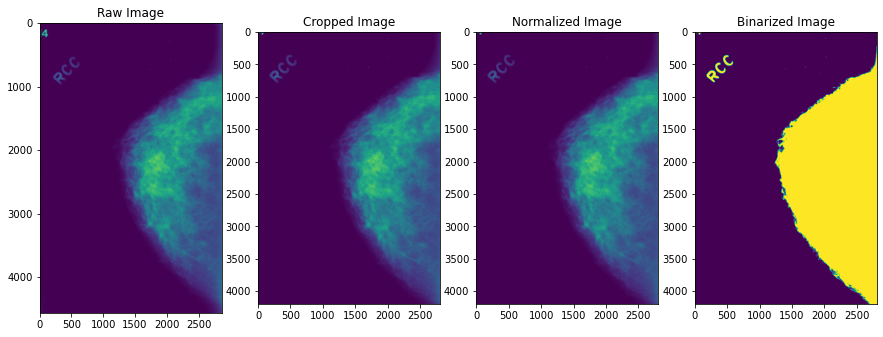

In [46]:
display_images([sample_image, cropped_image, normalized_image,binarized_image],
               ['Raw Image','Cropped Image','Normalized Image','Binarized Image'])

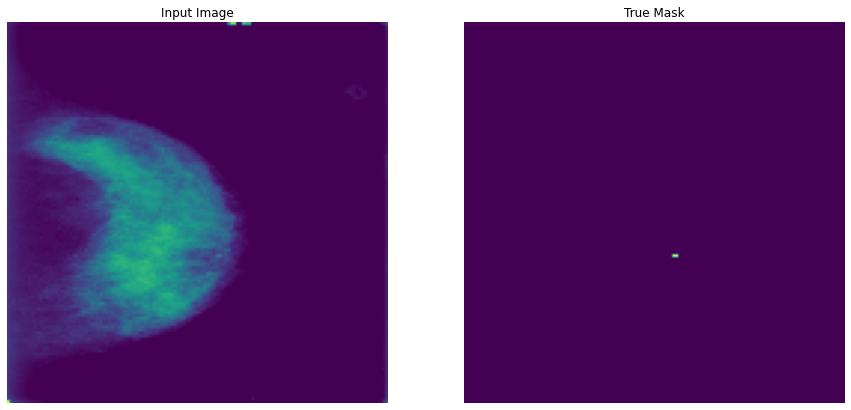

In [28]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [40]:
OUTPUT_CHANNELS = 1

In [42]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,1], include_top=False, weights=None)

layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [43]:
up_stack = [
    pix2pix.upsample(512,1),
    pix2pix.upsample(256,1),
    pix2pix.upsample(128,1),
    pix2pix.upsample(64,1),
]

In [44]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128,128,1])
    
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
    
    last = tf.keras.layers.Conv2DTranspose(output_channels, 1, strides=2, padding='same')
    
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model

In [52]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

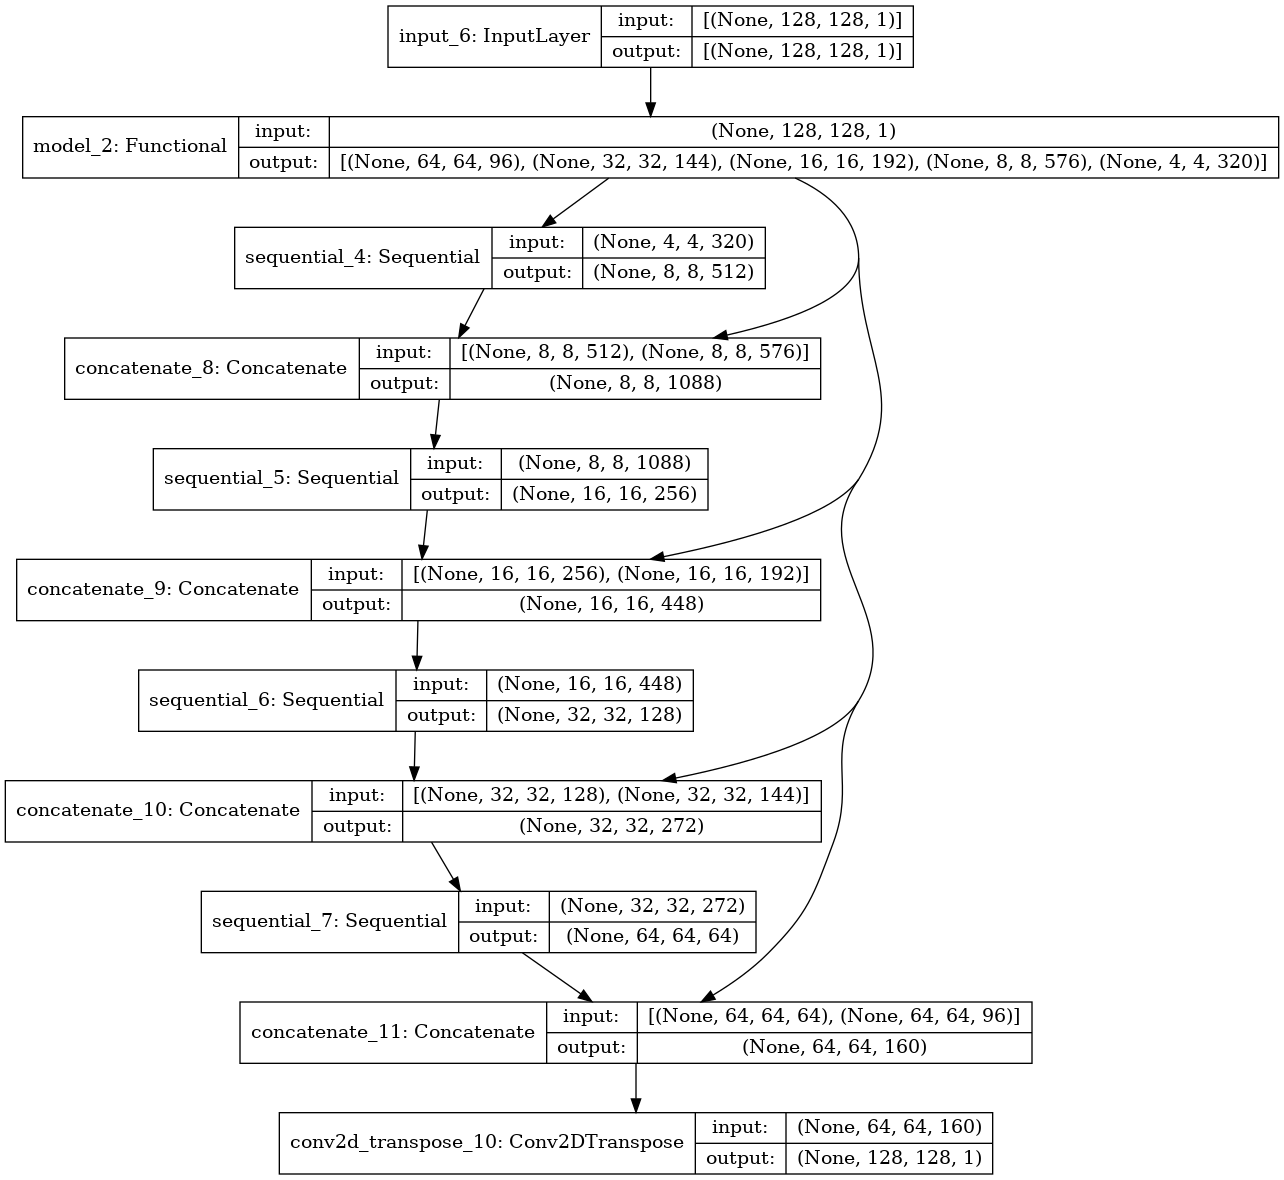

In [53]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [47]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [48]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis,...]))])

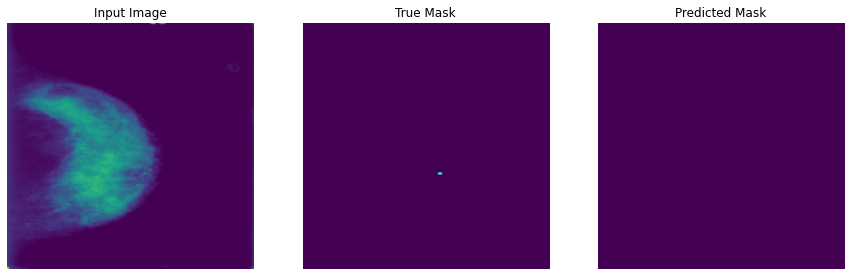

In [49]:
show_predictions()

In [50]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epic {}\n'.format(epoch+1))

In [54]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

Epoch 1/20


InvalidArgumentError:  Can not squeeze dim[0], expected a dimension of 1, got 2
	 [[{{node StatefulPartitionedCall/Squeeze}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_24356]

Function call stack:
train_function
